In [2]:
# Libraries
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as ss
from tqdm import trange
from copy import deepcopy
from tqdm import tqdm

In [3]:
# Global variables
n = 7
m = 11
points = [1,2, 3, 4, 5, 6, 7, 8, 9, 10] 
nArms = len(points)
b = [1 for i in range(nArms)]
a = [1 for i in range(nArms)]
InitialWorth = 1000 # the maximum number of points of each palyer

In [4]:
# Needed functions
def randmax(A):
    maxValue=max(A)
    index = [i for i in range(len(A)) if A[i]==maxValue]
    return np.random.choice(index)

def mapTo1422(sampled, a14, b22):
    return (b22-a14)*sampled+a14 

def softmax(x, tau):
    x = np.array(x)
    e = np.exp(x / tau)
    return list(e / e.sum())

### The class of cards

In [5]:
class Cards():
    def __init__(self):
        self.ncards = (m-n+1)*4  # number of cards
        self.cards = 4*[i for i in range(n,m+1)]  # cards 

    def shuffle(self):
        '''Knuth shuffle'''
        np.random.shuffle(self.cards)

    def hands(self):
        '''distribution of cards by the agent :)'''
        return [self.cards[0], self.cards[2]], [self.cards[1], self.cards[3]]

### The mean random attacker

In [6]:
class RandomMean():
    '''The random mean enemy '''
    def __init__(self, points = points, InitialWorth = InitialWorth):
        self.InitialWorth = InitialWorth # the maximum amount of points that the enemy has
        self.points = points
        
    def chooseAction(self, hand): # the enemy hand
        if sum(hand) >= 18:  # (the mean of all possible sum hands)
            return np.random.choice(self.points[5:])
        else:
            return np.random.choice(self.points[:5])

### Deterministic attacker

In [7]:
class Deterministic():
    "The detrerministic enemy"
    def __init__(self, InitialWorth = InitialWorth):
        self.InitialWorth = InitialWorth 
    
    def chooseAction(self, hand):
        return sum(hand) - 12

#### Human attacker

In [8]:
class Human():
    "By using this class, you can play against the agent as a human attacker"
    def __init__(self, InitialWorth = InitialWorth, points = points):
        self.InitialWorth = InitialWorth 
        self.points = points
        
    def chooseAction(self, hand):
        
        print("Your hand is:", hand)
        try:
            answer = int(input("Input your action in {0}: ".format(self.points))) 
        except:
            print("No strings please, try a number in ", self.points)
            
        while answer not in self.points:
            print("Try a number in ", self.points)
            answer = int(input("Input your action: "))  
            
        return answer 

### UCB1 agent

In [9]:
class UCB1():
    def __init__(self, alpha=0.1, nArms = nArms, InitialWorth = InitialWorth):
        self.alpha = alpha
        self.InitialWorth = InitialWorth
        self.armsMu = np.zeros((nArms,2*(m-n)+1)) # P(X/s=14)=E(1X/s=14) for exemple
        self.nbDraws = np.zeros((nArms,2*(m-n)+1)) # contain the number of draws of eatch arm
        self.estimatedSumEnemyHand = None
    
    def chooseArmToGo(self, hand, enAction): # like an arm
        # sample the distrubution of the arm number enAction
        if(enAction==1):
            # Always call it is a strategy
            return True 
        else:
            # According to the agent technique
            # We explore first all the arms
            if (min(self.nbDraws[enAction-1,:])==0): 
                 estimatedSumEnemyHand=randmax(-self.nbDraws[enAction-1,:])+14      
            else:
                mu=self.armsMu[enAction-1,:]/self.nbDraws[enAction-1,:] # the empirical mean after t-1 time
                t_1=np.sum(self.nbDraws[enAction-1,:])
                sqt_alpha_log=np.sqrt(self.alpha*np.log(t_1+1)/self.nbDraws[enAction-1,:])
                estimatedSumEnemyHand =randmax(mu+sqt_alpha_log)+14
            self.estimatedSumEnemyHand = estimatedSumEnemyHand
            
            # If the agent's hand is grater than the sampled enamy's hand
            if(sum(hand) >= estimatedSumEnemyHand): 
                return True 
            else :
                return False 
            
    def update(self, call, enAction, firstHand, secondHand):
        if(enAction != 1):
            self.nbDraws[enAction-1, self.estimatedSumEnemyHand-14] += 1
            if call and sum(secondHand)< sum(firstHand):
                self.armsMu[enAction-1,self.estimatedSumEnemyHand-14] -= enAction/10
            if  sum(secondHand) >= sum(firstHand) and not call:
                self.armsMu[enAction-1,self.estimatedSumEnemyHand-14] -= 1/10
            if call and sum(secondHand) > sum(firstHand):
                self.armsMu[enAction-1,self.estimatedSumEnemyHand-14] += enAction/10 

### Thompson agent

In [10]:
class ThompsonSampling:
    def __init__(self, alist = a, blist = b, alpha = 0.5, InitialWorth = InitialWorth):
        self.InitialWorth= InitialWorth 
        self.alist = deepcopy(alist)
        self.blist = deepcopy(blist)
        self.alpha = alpha

    def chooseArmToGo(self, hand, enAction): 
        if(enAction==1):
            return True # always go it is a strategy
        else:
            estimated = np.random.beta(self.alist[enAction-1], self.blist[enAction-1])
            estimatedSumEnemyHand = mapTo1422(estimated,14,22) # according to the agent technique
            if(sum(hand) >= estimatedSumEnemyHand): # if the agent hand is grater than the sampled enamy hand
                return True # Call
            else :
                return False # Fold
    
    def update(self, call, enAction, firstHand, secondHand):
        if(enAction !=1):
            if call and sum(secondHand)< sum(firstHand) :
                self.alist[enAction-1] += self.alpha*enAction # shift bata to the right 
            if sum(secondHand) >= sum(firstHand) and not call:    
                self.blist[enAction-1] += self.alpha*enAction # shift bata to the left

### Exp3 agent

In [11]:
class Exp3 :
    def __init__(self, lr = 1, nArms = nArms, InitialWorth = InitialWorth):
        self.InitialWorth = InitialWorth
        self.lr = lr
        self.armsIWE = np.ones((nArms,2*(m-n)+1)) # importance-weighted estimator
        self.ListSumHands = np.arange(2*n,2*m+1)
        self.estimatedSumEnemyHand = None
    
    def chooseArmToGo(self, hand, enAction): 
        if(enAction==1):
            return True # always Call it is a strategy
        else:
            # according to the agent technique
            estimatedSumEnemyHand = np.random.choice(self.ListSumHands,p=self.armsIWE[enAction-1, :]/(np.sum(self.armsIWE[enAction-1, :])))
            self.estimatedSumEnemyHand = estimatedSumEnemyHand
            if(sum(hand) >= estimatedSumEnemyHand): # if the agent hand is grater than the sampled enamy hand
                return True # Call
            else :
                return False # Fold
            
    def update(self, call, enAction, firstHand, secondHand):    
        if(enAction !=1):
            if call and sum(secondHand)< sum(firstHand) :
                self.armsIWE[enAction-1,self.estimatedSumEnemyHand-14]*=np.exp(-self.lr*enAction/10) 
            if sum(secondHand) >= sum(firstHand) and not call:    
                self.armsIWE[enAction-1,self.estimatedSumEnemyHand-14]*=np.exp(-self.lr/10) 
            if call and sum(secondHand) > sum(firstHand):
                self.armsIWE[enAction-1,self.estimatedSumEnemyHand-14]*=np.exp(self.lr*enAction/10) 
        # reward == 0 if call and h2==h1

### Td-learning agent

In [12]:
class tdLearning :
    def __init__(self, exp = .3, lr = .1, random = False, eta=2., InitialWorth = InitialWorth):
        self.InitialWorth= InitialWorth  
        self.points = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        self.statDict = {}
        self.exp = exp # Exploration rate
        self.lr = lr # Learning rate
        self.random = random 
        self.eta = eta 

    def chooseArmToGo(self, hand, enAction): 
        actions = [0, 1]
        state = str(sum(hand)) + "-" + str(enAction)
        
        if np.random.random() < self.exp or self.statDict.get(state) is None:
            return np.random.choice(actions)
        Dict = self.statDict.get(state)
        
        if self.random:
            # Using softmax to help our player take "unpredectible" actions.
            action = int(np.random.choice(list(Dict.keys()), p=softmax(list(Dict.values()), self.eta))[0])
        else:
            # Take the best action, the action who get the best reward!
            action = int(max(self.statDict.get(state), key = lambda x: self.statDict.get(state)[x]))
        return action
    
    def update(self, call, enAction, firstHand, secondHand):    
        state = str(sum(secondHand)) + "-" + str(enAction)
        
        if self.statDict.get(state) is None:
            self.statDict[state] = {}
        if self.statDict.get(state).get(str(call)) is None:
            self.statDict[state][str(call)] = 0
        
        if call:
            if sum(firstHand)>sum(secondHand):
                self.statDict[state][str(call)] += self.lr*( -enAction / 10. - self.statDict[state][str(call)])
            if sum(firstHand)<sum(secondHand):
                self.statDict[state][str(call)] += self.lr*( enAction / 10. - self.statDict[state][str(call)])
        
        if not call:    
            self.statDict[state][str(call)] += self.lr*( - .1 - self.statDict[state][str(call)])

### ______________________________________________________________ ###

In [13]:
def play(agent, enemy, display = True, human = False):
    "This function to play an agent against attacker (Human,UCB1,...)"
    while(enemy.InitialWorth>=10 and agent.InitialWorth>=10):
        cards = Cards()
        cards.shuffle()
        firstHand, secondHand = cards.hands()
        enAction = enemy.chooseAction(firstHand)
        agAction = agent.chooseArmToGo(secondHand, enAction)
        #show cards
        if agAction:
            if sum(firstHand)>sum(secondHand):
                # agent loses
                agent.InitialWorth -= enAction
            if sum(firstHand)<sum(secondHand):
                # agent loses
                enemy.InitialWorth -= enAction
        else :
            agent.InitialWorth -= 1
        # update agent strategy
        agent.update(agAction, enAction, firstHand, secondHand)
        
        if human:
            print("-- Human:")
            print("You went for :", enAction)
            print("Your Current Worth= ", enemy.InitialWorth)
            print("-- Agent:")
            print("The Agent hand was :", secondHand)
            print("The Agent went for :",agAction)
            print("The Agent Current Worth= ", agent.InitialWorth)
            print()

    if display:
        print("Agent have {0} points and enemy have {1} points".format(agent.InitialWorth, enemy.InitialWorth))

In [14]:
# UCB1 VS Random mean agent
agent, enemy = ThompsonSampling(), RandomMean()
play(agent, enemy)

Agent have 410 points and enemy have 7 points


Agent have 594 points and enemy have 6 points


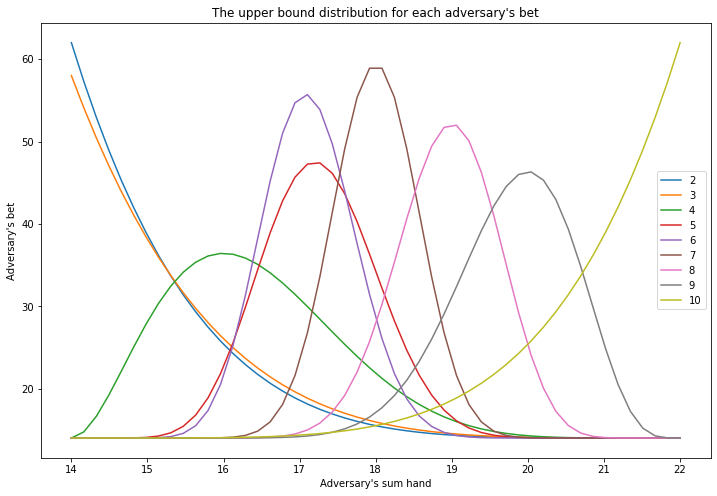

In [15]:
# Thompson Distibution 
agent, enemy = ThompsonSampling(), Deterministic()  # Thompson vs Deterministic (for example)
play(agent, enemy)

agAL = agent.alist
agBL = agent.blist

x  = np.linspace(0,1,50)
x_ = np.linspace(14,22,50)

plt.figure(figsize=(12,8),facecolor='white')

for i in range(1,10):
    y = ss.beta.pdf (x, agAL[i], agBL[i],loc=0, scale=1)
    plt.plot(x_,(22-14)*y+14,label=f"{i+1}")
    plt.legend()
    
plt.xlabel("Adversary's sum hand")
plt.ylabel("Adversary's bet")
plt.title("The upper bound distribution for each adversary's bet")
plt.show()

Agent have 100 points and enemy have 9 points


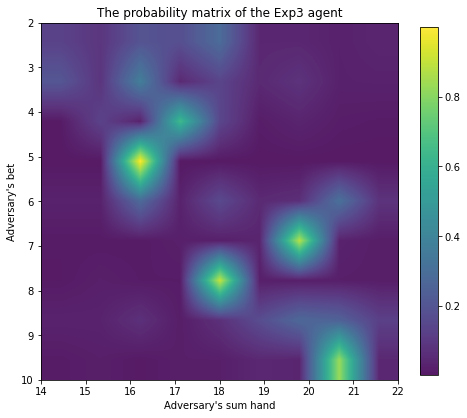

In [16]:
# Exp3 Distribution matrix
agent, enemy = Exp3(), RandomMean() # Exp3 vs Random mean 
play(agent, enemy)
armsIWEcopy = deepcopy(agent.armsIWE)

for i in range(10):
    armsIWEcopy[i,:] = armsIWEcopy[i,:]/np.sum(armsIWEcopy[i,:])

plt.figure(figsize=(8,8), facecolor='white')
extent = np.min(agent.ListSumHands), np.max(agent.ListSumHands), 10, 2

plt.imshow(armsIWEcopy[1:,],  cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear',extent=extent)
plt.colorbar(shrink=0.8)
plt.xlabel("Adversary's sum hand")
plt.ylabel("Adversary's bet")
plt.title("The probability matrix of the Exp3 agent")
plt.show()

Agent have 440 points and enemy have 8 points


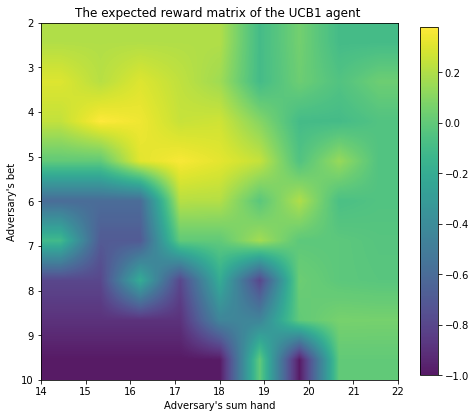

In [17]:
agent, enemy = UCB1(), Deterministic() ## UCB1 vs Deterministic
play(agent, enemy)
w = agent.armsMu[1:,:]/agent.nbDraws[1:,:]

plt.figure(figsize=(8,8), facecolor='white')
extent = 14, 22, 10, 2

plt.imshow(w,  cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear',extent=extent)
plt.colorbar(shrink=0.8)
plt.xlabel("Adversary's sum hand")
plt.ylabel("Adversary's bet")
plt.title("The expected reward matrix of the UCB1 agent ")
plt.show()

In [18]:
N = 50 # In our report we took 5000.
Delta =[]
roundsWon = []
roundsLost = []

for _ in tqdm(np.arange(N)):  
    enemy = RandomMean()
    agent = ThompsonSampling() # Choose your agent 
    it = 0
    while(enemy.InitialWorth >= 10 and agent.InitialWorth >= 10):
        cards = Cards()
        cards.shuffle()
        firstHand, secondHand = cards.hands()
        enAction = enemy.chooseAction(firstHand)
        agAction = agent.chooseArmToGo(secondHand, enAction)
        #show cards
        if agAction:
            if sum(firstHand)>sum(secondHand):
                # agent loses
                agent.InitialWorth -= enAction
            if sum(firstHand)<sum(secondHand):
                # agent loses
                enemy.InitialWorth -= enAction
        else :
            agent.InitialWorth -= 1
        # update agent strategy
        agent.update(agAction, enAction, firstHand, secondHand)
        it += 1
    
    if(enemy.InitialWorth <10):
        roundsWon.append(it)
    if(agent.InitialWorth <10):
        roundsLost.append(it)
    Delta.append(agent.InitialWorth - enemy.InitialWorth)
    
print("The average gap between the two:", np.mean(np.array(Delta)/InitialWorth))
print("Number of rounds won  :", len(roundsWon))
print(" the average number of necessary rounds to win a game  :", np.mean(np.array(roundsWon)))
print("Number of rounds lost :", len(roundsLost))
print(" the average number of necessary rounds to be defeated :", np.mean(np.array(roundsLost)))

100%|██████████| 50/50 [00:00<00:00, 97.55it/s]

The average gap between the two: 0.38370000000000004
Number of rounds won  : 50
 the average number of necessary rounds to win a game  : 574.56
Number of rounds lost : 0
 the average number of necessary rounds to be defeated : nan



/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Play

Please uncomment the code below. To bet No strings please, try a number in  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [21]:
# agent = ThompsonSampling()
# play(agent, Deterministic(), display = False) # to make the agent more efficient before playing
# agent.InitialWorth = InitialWorth
# play(agent, Human(), human = True)